# Analyzing NYC High School Data

One of the most controversial issues in the U.S. educational system is the efficacy of standardized tests, and whether they're unfair to certain groups. Given our prior knowledge of this topic, in this project we decided to investigate the correlations between SAT scores and demographics and other elements that may correlate SAT scores with factors like race, gender, income, and more.

The SAT, or Scholastic Aptitude Test, is an exam that U.S. high school students take before applying to college. Colleges take the test scores into account when deciding who to admit, so it's fairly important to perform well on it.

The test consists of three sections, each of which has 800 possible points. The combined score is out of 2,400 possible points (while this number has changed a few times, the data set for our project is based on 2,400 total points). Organizations often rank high schools by their average SAT scores. The scores are also considered a measure of overall school district quality.

New York City makes its data on high school SAT scores available online, as well as the demographics for each high school. The same website has several related data sets covering demographic information and test scores. Here are the links to all of the data sets we'll be using:

* [SAT scores by school](https://data.cityofnewyork.us/Education/2012-SAT-Results/f9bf-2cp4) - SAT scores for each high school in New York City
* [School attendance](https://data.cityofnewyork.us/Education/2010-2011-School-Attendance-and-Enrollment-Statist/7z8d-msnt) - Attendance information for each school in New York City
* [Class size](https://data.cityofnewyork.us/Education/2010-2011-Class-Size-School-level-detail/urz7-pzb3) - Information on class size for each school
* [AP test results](https://data.cityofnewyork.us/Education/2010-AP-College-Board-School-Level-Results/itfs-ms3e) - Advanced Placement (AP) exam results for each high school (passing an optional AP exam in a particular subject can earn a student college credit in that subject)
* [Graduation outcomes](https://data.cityofnewyork.us/Education/2005-2010-Graduation-Outcomes-School-Level/vh2h-md7a) - The percentage of students who graduated, and other outcome information
* [Demographics](https://data.cityofnewyork.us/Education/2006-2012-School-Demographics-and-Accountability-S/ihfw-zy9j) - Demographic information for each school
* [School survey](https://data.cityofnewyork.us/Education/2011-NYC-School-Survey/mnz3-dyi8) - Surveys of parents, teachers, and students at each school
* [Home prices](https://www.kaggle.com/new-york-city/nyc-property-sales) - A record of every building or building unit (apartment, etc.) sold in the New York City property market over a 12-month period.

All of these data sets are interrelated. We'll need to combine them into a single data set before we can find correlations. But at first we will tackle the essential part of data exploration : 
* data cleaning and 
* handling missing data  


# Read in the data

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv(f)
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pd.read_csv("survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [10]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [11]:
#Set up matplotlib to work in Jupyter notebook.
import matplotlib.pyplot as plt
%matplotlib inline 

In [12]:
# a list of survey fields and sat_score
survey_fields.append('sat_score')


([], <a list of 0 Text xticklabel objects>)

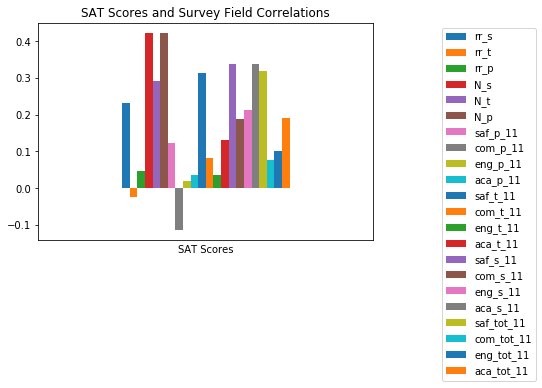

In [13]:
# Correlations between SAT scores and survey fields
sat_score_corr_surveys=combined[survey_fields].corr().iloc[-1:,:-1]
sat_score_corr_surveys.T
sat_score_corr_surveys.plot(kind='bar').legend(bbox_to_anchor=(1.5,1))
plt.title('SAT Scores and Survey Field Correlations', color='black')
plt.xlabel('SAT Scores')
plt.xticks([], [])

We will consider a Pearson correlation coefficient value r as statistically important if r turns out to be  bigger than 0.3 and less than -0.3.
While the correlations between SAT Scores and number of student respondents, SAT Scores and number of parent respondents are at a moderate level, interestingly  number of teacher respondents has weaker association with SAT Scores.
Safety and respect scores given by students and teaches and their totals are positively linked to SAT Scores. Finally we can observe a positive association between academic expectation scores based on student responds and SAT Scores. 
On the other hand, academic expectation scores based on teacher responds seem irrelevant. 


Text(0.5, 0, 'Safety Scores by Students')

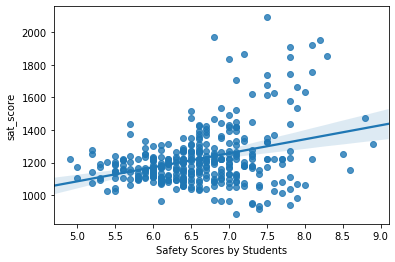

In [14]:
#  A scatter plot of the safety scores vs. the sat_score 
#  with the regression line
sns.regplot(combined['saf_s_11'],combined['sat_score'])
# combined.plot(kind='scatter', x='saf_s_11',y='sat_score')
plt.xlabel('Safety Scores by Students')
# plt.xticks([], [])

As easily can be seen from the scatter plot and regression line, SAT Scores and safety scores based on student answers are highly correlated.

In [15]:
# Compute the average SAT Score and Safety Score for each district.
districts=combined.groupby('school_dist')[['sat_score','saf_s_11','lon','lat']].\
agg(np.mean).rename(columns=\
                    {'sat_score':'SAT Score','saf_s_11':'Safety Score'})
districts.reset_index(inplace=True)
print(districts)

   school_dist    SAT Score  Safety Score        lon        lat
0           01  1354.500000      6.768611 -73.982377  40.719022
1           02  1295.638184      6.910660 -73.991386  40.739699
2           03  1293.443035      6.716667 -73.977370  40.781574
3           04  1224.142857      6.885714 -73.943215  40.793449
4           05  1285.062687      6.314286 -73.949251  40.817077
5           06  1164.643881      6.950000 -73.932502  40.848970
6           07  1128.846154      6.800000 -73.919971  40.816815
7           08  1159.665129      6.364697 -73.866087  40.823803
8           09  1131.971940      6.655000 -73.906240  40.836349
9           10  1222.227273      6.577273 -73.898360  40.870345
10          11  1165.000000      6.186667 -73.856120  40.873138
11          12  1101.823134      7.116667 -73.886946  40.831412
12          13  1237.187600      6.407692 -73.977016  40.692865
13          14  1179.459915      6.685714 -73.948360  40.711599
14          15  1190.604312      6.17777

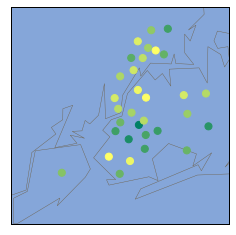

In [16]:
# Map out safety scores by district

import os
os.environ['PROJ_LIB'] = r'C:\Users\MIQDAD\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

try:
    from inspect import cleandoc as dedent
except ImportError:
    # Deprecated as of version 3.1. Not quite the same
    # as textwrap.dedent.
    from matplotlib.cbook import dedent
    
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
longitudes=districts['lon'].tolist()
latitudes=districts['lat'].tolist()
m.scatter(longitudes,latitudes,s=50,zorder=2,latlon=True,\
          c=districts["Safety Score"],cmap="summer") 

plt.show()

When we look at SAT Score  and Safety score averages for each district, the association is obvious. When safety score averages are mapped  by district, the south districts seem less safe. Note that yellow points indicate high safety and green dots denote lower safety score averages. 

### Racial differences in SAT scores

([], <a list of 0 Text xticklabel objects>)

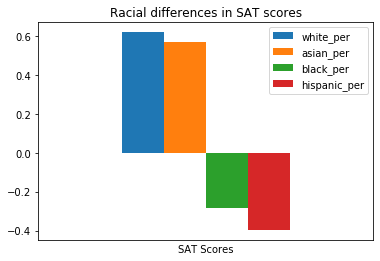

In [17]:
# Columns list containing races percantages and SAT score 
race_per=['white_per'
,'asian_per'
,'black_per'
,'hispanic_per','sat_score']

# Correlations between SAT scores and Races
sat_score_corr_races=combined[race_per].corr().iloc[-1:,:-1]
sat_score_corr_races.T

# Bar graph of corrrelations between SAT Scores and Race percentages
sat_score_corr_races.plot(kind='bar').legend(bbox_to_anchor=(1,1))
plt.title('Racial differences in SAT scores', color='black')
plt.xlabel('SAT Scores')
plt.xticks([], [])


By looking at the bar graph of the correlations between SAT Scores and races percentages. it can be deduced that on average  white and asian students get higher scores on the test than black and hispanic students.
The strong negative association with hispanic student percentage is quite salient.

Text(0.5, 0, 'Hispanic Student Percentage')

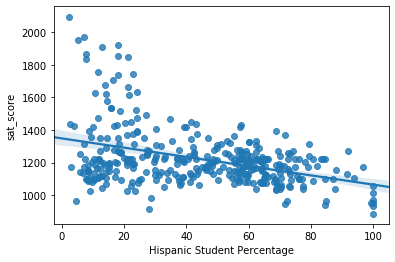

In [18]:
#  A scatter plot of the hispanic percentage vs. the sat_score 
#  with the regression line
sns.regplot(combined['hispanic_per'],combined['sat_score'])
plt.xlabel('Hispanic Student Percentage')
#plt.xticks([], [])

The scatter plot of hispanic student percentage and SAT Score also justifies our previous observation.

In [19]:
# List of schools with very high hispanic student population
combined[combined['hispanic_per']>95]['SCHOOL NAME']

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

In NYC, only 8 high schools have hispanic student population above 95%. 
After a quick google search, we see that only one school is in within top 1000 national rankings based on their performance on state-required tests, graduation and how well they prepare students for college.
* Manhattan Bridges High School is ranked #363 in the National Rankings.
* Multicultural High School is ranked #12,555 in the National Rankings.
* Pan American International High School is ranked #3,013 in the National Rankings.
* Academy for Language and Technology is ranked #1,040 in the National Rankings.
* Gregorio Luperon High SchoolFor Science and Mathemat is ranked #2,955 in the National Rankings.
* Pan American International High School at Monroe is ranked #1,075 in the National Rankings.
* International School for Liberal Arts is ranked #2,401 in the National Rankings.
* Academy for Language and Technology is ranked #1,040 in the National Rankings.



In [20]:
# Schools with a hispanic_per less than 10% and 
# an average SAT score greater than 1800.
combined[(combined['hispanic_per']<10) & (combined['sat_score']>1800)]['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

When filtered the schools dataframe with criteria hispanic population less than 10% and average SAT score of 1800, only five scholls show up. After  a quick research, we obtain the following striking info:
* Stuyvesant High School is ranked #25 in the National Rankings
* Bronx High School of Science is ranked #36 in the National Rankings.
* Brooklyn Technical High School is ranked #47 in the National Rankings.
* Queens High School for the Sciences at York College is ranked #28 in the National Rankings.
* Staten Island Technical High School is ranked #35 in the National Rankings.


### Gender differences in SAT scores

In [21]:
# Columns list with gender percentages and SAT score 
gender_per=['female_per'
,'male_per'
,'sat_score']

# Correlations between SAT scores and Genders
sat_score_corr_genders=combined[gender_per].corr().iloc[-1:,:-1]
sat_score_corr_genders.T



,sat_score
female_per,0.112108
male_per,-0.112062


([], <a list of 0 Text xticklabel objects>)

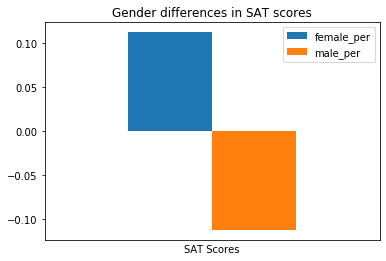

In [22]:
# Bar graph of corrrelations between SAT Scores and Genders
sat_score_corr_genders.plot(kind='bar').legend(bbox_to_anchor=(1,1))
plt.title('Gender differences in SAT scores', color='black')
plt.xlabel('SAT Scores')
plt.xticks([], [])

The correlation between the SAT Scores and gender percentages is weak. But we observe a slight
positive association gender proportion and the test scores.
It looks like the gender make-up of the school does not play a big role on SAT scores.

Text(0.5, 0, 'Female Percentage')

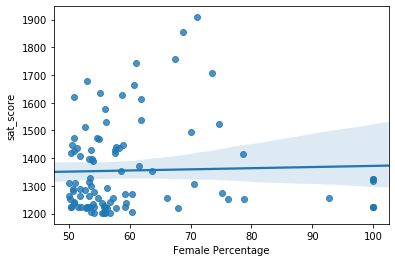

In [23]:
# Schools with SAT scores higher than 1200 and more female students.

more_fem_high_SAT=combined[(combined['female_per']>50) & \
                           (combined['sat_score']>1200)]

#  A scatter plot of the female percentage vs. the sat_score 
#  with the regression line
sns.regplot(more_fem_high_SAT['female_per'],more_fem_high_SAT['sat_score'])
plt.xlabel('Female Percentage')
#plt.xticks([], [])

The scatter plot also supports our earlier finding.
The regression line is almost flat which indicates that there is not a significant association between the columns.

In [24]:
# Schools with a female_per greater than 60% and 
# an average SAT score greater than 1700.
combined[(combined['female_per']>60) & \
                           (combined['sat_score']>1700)]


,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,...,0,0,0,0,0,0,"411 East 76 Street\nNew York, NY 10021\n(40.77...",40.770116,-73.953379,02
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000000,...,0,0,0,0,0,0,"227-243 West 61St Street\nNew York, NY 10023\n...",40.772158,-73.987797,03
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,1236.000000,...,0,0,0,0,0,0,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",40.773671,-73.985269,03
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,0,0,0,0,0,0,"149-11 Melbourne Avenue\nFlushing, NY 11367\n(...",40.734408,-73.821417,25


There are five schools with SAT score average above 1700 and female student percentage higher than 60%. We pulled up the data below about those schools: 
* Townsend Harris High School is ranked #5 in the National Rankings.
* BARD HIGH SCHOOL EARLY COLLEGE #16 in Best Public High Schools in New York
* Eleanor Roosevelt High School is ranked #162 in the National Rankings.
* Beacon High School is ranked #479 in the National Rankings.
* Fiorello H Laguardia High School is ranked #181 in the National Rankings.




### Advanced Placement (AP) exams and SAT scores

Text(0.5, 0, "AP Test Takers' Proportion")

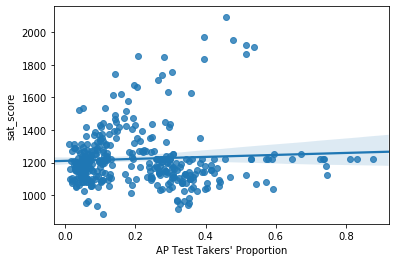

In [25]:
#The percentage of students in each school that took an AP exam
combined['ap_per']=combined['AP Test Takers ']/combined['total_enrollment']
#  A scatter plot of the female percentage vs. the sat_score 
#  with the regression line
sns.regplot(combined['ap_per'],combined['sat_score'])
plt.xlabel("AP Test Takers' Proportion")
# plt.xticks([], [])

In [26]:
# Correlation coefficient between AP Test takers' proportion  and sat_score
combined[['ap_per','sat_score']].corr()

,ap_per,sat_score
ap_per,1.000000,0.057171
sat_score,0.057171,1.000000


The correlation coefficient and scatter plot depicting the link between the SAT scores and AP Test takers' proportion numerically and visually are consistent with each other and both suggest the idea that there is no correlation!

# Good Schools and Home Prices
In this part we will analyze the correlation between average sat score and home prices by zip codes.
A dataset which is  available on https://www.kaggle.com/new-york-city/nyc-property-sales will be used. This dataset is a record of every building or building unit (apartment, etc.) sold in the New York City property market over a 12-month period.


In [60]:
# Read the dataset into pandas dataframe
nyc_home_prices=pd.read_csv('nyc-rolling-sales.csv')
nyc_home_prices.columns

Index(['Unnamed: 0', 'BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object')

In [62]:
#Check data
nyc_home_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 22 columns):
Unnamed: 0                        84548 non-null int64
BOROUGH                           84548 non-null int64
NEIGHBORHOOD                      84548 non-null object
BUILDING CLASS CATEGORY           84548 non-null object
TAX CLASS AT PRESENT              84548 non-null object
BLOCK                             84548 non-null int64
LOT                               84548 non-null int64
EASE-MENT                         84548 non-null object
BUILDING CLASS AT PRESENT         84548 non-null object
ADDRESS                           84548 non-null object
APARTMENT NUMBER                  84548 non-null object
ZIP CODE                          84548 non-null int64
RESIDENTIAL UNITS                 84548 non-null int64
COMMERCIAL UNITS                  84548 non-null int64
TOTAL UNITS                       84548 non-null int64
LAND SQUARE FEET                  84548 non-null object
GRO

In [63]:
# Convert 'SALE PRICE' column to numeric data type.
nyc_home_prices['SALE PRICE_float']=pd.to_numeric(nyc_home_prices['SALE PRICE'],errors='coerce')

In [67]:
# Find zipcode of school from coordinates (latitute,longitude)
import geopy
def get_zipcode(df, geolocator, lat_field, lon_field):
    location = geolocator.reverse((df[lat_field], df[lon_field]))
    return location.raw['address']['postcode']


geolocator = geopy.Nominatim(user_agent='my-application')

zipcodes = combined.apply(get_zipcode, axis=1, geolocator=geolocator, lat_field='lat', lon_field='lon')


object


In [76]:
# Verify if the zip column is consistent with the zipcodes obtained from coordinates
mask=zipcodes.astype(int)!=combined['zip']
mask.sum()
combined['zipcodes_from_coor']=zipcodes
combined[mask][['SCHOOL NAME','zip','zipcodes_from_coor']]

,SCHOOL NAME,zip,zipcodes_from_coor
15,URBAN ASSEMBLY SCHOOL OF BUSINESS FOR YOUNG WO...,10004,10275
17,NYC ISCHOOL,10013,10005
48,RICHARD R. GREEN HIGH SCHOOL OF TEACHING,10004,10275
51,CHELSEA CAREER AND TECHNICAL EDUCATION HIGH SC...,10013,10005
90,SOUTH BRONX PREPARATORY: A COLLEGE BOARD SCHOOL,10454,10455
192,BEDFORD ACADEMY HIGH SCHOOL,11216,11226
196,JUAN MOREL CAMPOS SECONDARY SCHOOL,11206,11211
200,PROGRESS HIGH SCHOOL FOR PROFESSIONAL CAREERS,11211,11206
201,SCHOOL FOR LEGAL STUDIES,11211,11206
202,"THE HIGH SCHOOL FOR ENTERPRISE, BUSINESS AND T...",11211,11206


There are 27 mismatches. After a quick search, the zip column of the dataset turned out to be the right zip codes of schools.
The coordinates of the schools might be wrong so we decided to use 'zip' codes for our research.

In [79]:
# We clean 'ZIP CODE' column by eliminating values whose length is different than 5 digits.
mask=nyc_home_prices['ZIP CODE'].apply(lambda x: len(str(x))==5)
nyc_home_prices=nyc_home_prices[mask]

In [105]:
# Checking for outliers in SALE PRICE column
nyc_home_prices['SALE PRICE_float'].sort_values(ascending=False).head(10)

34243    1499500.0
6502     1499373.0
1582     1499000.0
1667     1499000.0
42859    1499000.0
10775    1499000.0
31743    1499000.0
6980     1498000.0
16626    1498000.0
49709    1498000.0
Name: SALE PRICE_float, dtype: float64

In [106]:
# Remove outliers
mask=nyc_home_prices['SALE PRICE_float']< 2.5e+06
nyc_home_prices=nyc_home_prices[mask]

Text(0.5, 0, 'SALE PRICE')

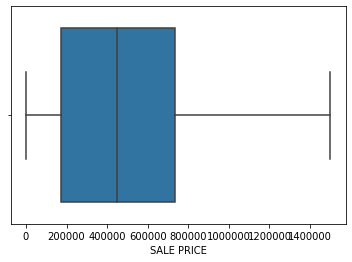

In [108]:
# With the help of a boxplot, check the data for outliers
sns.boxplot(x=nyc_home_prices['SALE PRICE_float'])
plt.xlabel('SALE PRICE')

In [117]:
# Average home prices by zip codes
nyc_home_prices_zip=nyc_home_prices.groupby('ZIP CODE')['SALE PRICE_float'].agg({'Average Home Price':np.mean})
nyc_home_prices_zip.reset_index(inplace=True)

In [120]:
# Average SAT scores by zip codes
school_sat_zip=combined.groupby('zip')['sat_score'].agg({'Average SAT Score':np.mean})
school_sat_zip.reset_index(inplace=True)
school_sat_zip

,zip,Average SAT Score
0,10002,1306.090909
1,10003,1232.219403
2,10004,1287.000000
3,10006,1303.500000
4,10009,1149.000000
...,...,...
111,11432,1318.073134
112,11433,1545.719403
113,11434,1152.000000
114,11691,1131.666667


In [119]:
# Prepare datasets for merging on 'zip' column

# Change column name to 'zip'
nyc_home_prices_zip.rename(columns={'ZIP CODE':'zip'},inplace=True)
nyc_home_prices_zip

,zip,Average Home Price
0,10001,664748.942029
1,10002,765062.300000
2,10003,855342.643059
3,10004,779892.428571
4,10005,992884.758242
...,...,...
177,11436,393493.975410
178,11691,420586.866667
179,11692,419986.278261
180,11693,345358.475248


In [123]:
# Merge datsets
averages_by_zip=pd.merge(school_sat_zip,nyc_home_prices_zip,on='zip',how='inner')
averages_by_zip

,zip,Average SAT Score,Average Home Price
0,10002,1306.090909,765062.300000
1,10003,1232.219403,855342.643059
2,10004,1287.000000,779892.428571
3,10006,1303.500000,905068.804348
4,10009,1149.000000,777514.419355
...,...,...,...
111,11432,1318.073134,541105.549383
112,11433,1545.719403,395448.205047
113,11434,1152.000000,400513.585635
114,11691,1131.666667,420586.866667


In [127]:
# Correlation between SAT Scores and home prices
averages_by_zip[['Average SAT Score','Average Home Price']].corr()

,Average SAT Score,Average Home Price
Average SAT Score,1.000000,0.378465
Average Home Price,0.378465,1.000000


The Pearson correlation coefficient r=0.378465 shows a strong positive association.
Rich areas can prepare their kids better for the SAT exam.

Text(0.5, 0, 'Average Home Price')

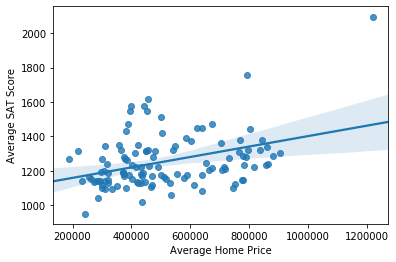

In [129]:
#  A scatter plot of the average home prices vs. sat_score 
#  with the regression line
sns.regplot(averages_by_zip['Average Home Price'],averages_by_zip['Average SAT Score'])
plt.xlabel("Average Home Price")
# plt.xticks([], [])

In [142]:
# List of best schools with respect to SAT scores in each area
comb=combined.sort_values(['zip','sat_score'],ascending=False).groupby('zip').head(1)

In [144]:
# Merge best schools with average home prices
best_schools=comb[['zip','SCHOOL NAME','sat_score','lon','lat']].merge(nyc_home_prices_zip,on='zip',how='inner')
best_schools['Average Home Price']=best_schools['Average Home Price'].astype(int)
best_schools[['zip','SCHOOL NAME','sat_score','Average Home Price']]

,zip,SCHOOL NAME,sat_score,Average Home Price
0,11694,SCHOLARS' ACADEMY,1532.0,584808
1,11691,"QUEENS HIGH SCHOOL FOR INFORMATION, RESEARCH, ...",1156.0,420586
2,11434,HIGH SCHOOL FOR LAW ENFORCEMENT AND PUBLIC SAFETY,1196.0,400513
3,11433,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,1868.0,395448
4,11432,QUEENS GATEWAY TO HEALTH SCIENCES SECONDARY SC...,1538.0,541105
...,...,...,...,...
111,10009,EAST SIDE COMMUNITY SCHOOL,1149.0,777514
112,10006,HIGH SCHOOL OF ECONOMICS AND FINANCE,1374.0,905068
113,10004,MILLENNIUM HIGH SCHOOL,1614.0,779892
114,10003,HIGH SCHOOL FOR HEALTH PROFESSIONS AND HUMAN S...,1306.0,855342


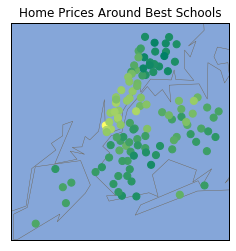

In [155]:
# Map out home prices around best schools 
import os
import matplotlib as mpl
os.environ['PROJ_LIB'] = r'C:\Users\MIQDAD\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
longitudes=best_schools['lon'].tolist()
latitudes=best_schools['lat'].tolist()
m.scatter(longitudes,latitudes,s=50,zorder=2,latlon=True,\
          c=best_schools['Average Home Price'],cmap="summer") 

plt.title('Home Prices Around Best Schools')

plt.show()

Note that yellow points indicate high and green dots denote low home price averages.
Nort part of NYC seems to have nice schools with an affordable neighborhood. 


## Conclusions
In this project, we analyzed datasets related to NYC High Schools and investigated the correlations between SAT scores and demographics and other elements that may correlate SAT scores with factors like race, gender, income, and more.
We employed data visualization tools and summary statistics to see the correlations between the variables.

Based on the data and our research, we conclude that:

* As the parent and student engagement in school surveys increases so are SAT scores. On the other hand, the number of teacher respondents has weak association.
* Safety and respect scores given by students and teaches and their totals are positively linked to SAT Scores. 
* We observed a positive association between academic expectation scores based on student responds and SAT Scores. But academic expectation scores based on teacher responds and test scores seemed weakly correlated. 
* By looking at the bar graph of the correlations between SAT Scores and races percentages. On average white and asian students get higher scores on the test than black and hispanic students. The strong negative association with hispanic student percentage is quite salient. 
* The correlation between the SAT Scores and gender percentages is weak. But we observe a slight positive association between the female proportion and the test scores. It looks like the gender make-up of the school does not play a big role on SAT scores.
* There is a strong correlation between exam scores and home prices. This was a quite expected result since money plays an important role for the exam preparation. 